<a href="https://colab.research.google.com/github/wizz92/seo_ai/blob/main/Analyzing_Click_Stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Find clusters of related queries 
---

In this tutorial we will use [Microsoft ORCAS](https://microsoft.github.io/msmarco/ORCAS.html), **an amazing click-based dataset** including 10 million distinct queries, to find cluster of related queries.

We will cover the following:

1. Downloading ORCAS
2. Filtering the dataset
3. Generating the embeddings using [SentenceTransformer](https://www.sbert.net/) 
4. Clustering queries
5. Exporting the embeddings to the Projector format 

The MS MARCO and ORCAS datasets are intended for non-commercial research purposes only to promote advancement in the field of artificial intelligence and related areas, and is made available free of charge without extending any license or other intellectual property rights.

---

<table align="left">
  <td>
  <a href="https://wordlift.io">
    <img width=130px src="https://wordlift.io/wp-content/uploads/2018/07/logo-assets-510x287.png" />
    </a>
    </td>
    <td>
      by 
      <a href="https://wordlift.io/blog/en/entity/andrea-volpini">
        Andrea Volpini
      </a>
      <br/>
      <br/>
       MIT License (for this Colab)
      <br/>
       CC Attribution 4.0 International (for ORCAS).
      <br/>
      <br/>
      <i>Last updated: <b>November 13th, 2021</b></i>
  </td>
</table>
</br>
</br>

In [2]:
%%capture 

!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan

import pandas as pd

from sentence_transformers import SentenceTransformer
from google.colab import files

## 1. Downloading ORCAS

ORCAS: 18 Million Clicked Query-Document Pairs for Analyzing Search </br>
author=Craswell, Nick and Campos, Daniel and Mitra, Bhaskar and Yilmaz, Emine and Billerbeck, Bodo </br>
journal=arXiv preprint arXiv:2006.05324</br>
year=2020</br>


In [3]:
!wget https://msmarco.blob.core.windows.net/msmarcoranking/orcas-doctrain-queries.tsv.gz

--2023-03-26 19:09:10--  https://msmarco.blob.core.windows.net/msmarcoranking/orcas-doctrain-queries.tsv.gz
Resolving msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)... 20.150.34.4
Connecting to msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)|20.150.34.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104209356 (99M) [application/x-gzip]
Saving to: ‘orcas-doctrain-queries.tsv.gz’

orcas-doctrain-quer 100%[===================>]  99.38M  5.79MB/s    in 19s     

2023-03-26 19:09:30 (5.36 MB/s) - ‘orcas-doctrain-queries.tsv.gz’ saved [104209356/104209356]



In [4]:
!gzip -d "/content/orcas-doctrain-queries.tsv.gz"

In [5]:
df = pd.read_csv('/content/orcas-doctrain-queries.tsv', 
                 sep='\t', names=['qid', 'query'])
df

,qid,query
0,9265503,github
1,6832981,youtube
2,9571352,!
3,4896888,! c
4,10001890,! c++
...,...,...
10405306,3111367,ð¤¦ð½ââï¸
10405307,9364218,ð¤¨ meaning
10405308,10717906,ð¤© meaning
10405309,10942226,ð¤ª emoji


## 2. Filtering the dataset 

Here the goal is to define a list of queries that will be used for the expansion. We will basically filter any query that contain the list of terms that provided below. 

In [6]:
#@title Add here the list of queries that you want to expand 

queries = 'homework, writing service, essay, paper writing, write paper for me' #@param {type:"string"}
queries_list = [x.strip() for x in queries.lower().split(',')] 


In [7]:
df_filtered = df[df['query'].notnull()][df['query'].dropna().str.contains('|'.join(queries_list), regex=True)]
df_filtered.reset_index(inplace=True)


In [8]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4444 entries, 0 to 4443
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   4444 non-null   int64 
 1   qid     4444 non-null   int64 
 2   query   4444 non-null   object
dtypes: int64(2), object(1)
memory usage: 104.3+ KB


In [9]:
print("we have:", len(df_filtered), " queries")

we have: 4444  queries


In [10]:
df_filtered['query'].head(20)

0               10 reasons why homework is bad
1     10 reasons why homework should be banned
2                  100 discursive essay topics
3                             100% free essays
4                              1000 word essay
5                                    123 essay
6                        123 free essay papers
7                               123 help essay
8                             123helpme essays
9                              1500 word essay
10                          1st grade homework
11                   1st grade homework sheets
12                     1st grade math homework
13                             2000 word essay
14                     2000 word essay example
15            3 page essay on online education
16                           3 paragraph essay
17                   3 paragraph essay example
18                    3 paragraph essay format
19                   3 paragraph essay outline
Name: query, dtype: object

### Alternatively analyze only a subset of queries from the dataset

We can alternatively look at the dataset and compute the embeddings for, let's say the first 3M queries. This works on Colab provided that you have the Pro account and you use a GPU and a High Memory runtime. Do not run the cell below if you are already filtering the dataset in the previous steps.  

In [10]:
df_filtered = df[:2000000]
df_filtered.reset_index(inplace=True)

len(df_filtered)

2000000

## 3. Generating the embeddings

In [11]:
sentence_bert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

def get_embeddings(sentences):
    return sentence_bert_model.encode(sentences,
                                    batch_size=32, 
                                    show_progress_bar=True)

In [12]:
df_filtered

,index,qid,query
0,27922,2491390,10 reasons why homework is bad
1,27923,4325768,10 reasons why homework should be banned
2,30110,11190240,100 discursive essay topics
3,31562,7155605,100% free essays
4,32328,7569700,1000 word essay
...,...,...,...
4439,10207835,10393897,www.homeworkmarket.com
4440,10207836,8596631,www.homeworkmarket.com login
4441,10246671,7816584,www.primaryhomeworkhelp.co.uk
4442,10246672,12229286,www.primaryhomeworkhelp.co.uk/romans.html


In [13]:
e = get_embeddings(df_filtered['query'])

Batches:   0%|          | 0/139 [00:00<?, ?it/s]

In [22]:
e

array([[-0.49493992, -0.15413205, -0.19529387, ..., -0.04652803,
         0.0431857 ,  0.1512184 ],
       [-0.00178566,  0.44582388, -0.01454886, ...,  0.20798342,
        -0.16588224, -0.1276218 ],
       [ 0.30103076,  0.3245095 ,  0.5981241 , ..., -0.214566  ,
        -0.46596858, -0.37787044],
       ...,
       [-0.49303526,  0.63614583,  0.39935234, ..., -0.26031563,
         0.128408  ,  0.46384937],
       [-0.12304448,  0.48367625,  0.68074065, ..., -0.46852693,
         0.01066977,  0.36450505],
       [-1.0830734 ,  0.03642013, -0.12653264, ...,  0.6483225 ,
        -0.19071539, -0.06710815]], dtype=float32)

## 4. Clustering

In [14]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(e)

In [15]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

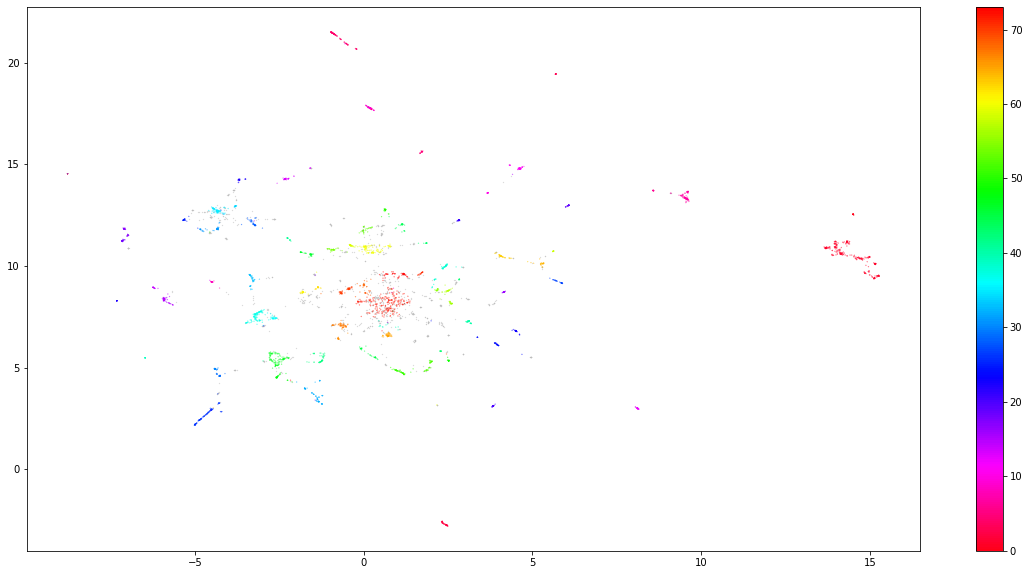

In [16]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(e)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [17]:
docs_df = pd.DataFrame(df_filtered, columns=["query"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'query': ' '.join})

In [18]:
docs_per_topic = docs_per_topic[ ['query'] + [ col for col in docs_per_topic.columns if col != 'query' ] ]
docs_per_topic

,query,Topic
0,123 essay 123 help essay 2000 word essay 2000 ...,-1
1,algebra 2 homework solver free do my math home...,0
2,10 reasons why homework is bad 10 reasons why ...,1
3,comparative essay introduction examples compar...,2
4,an opinion essay essay about music essay on mu...,3
...,...,...
70,adoption essay draft essay draft essay example...,69
71,basic essay outline constitution essay definit...,70
72,check my essay for grammar check my essay gram...,71
73,123helpme essays an essay an example of an ess...,72


## 5. Exporting embeddings using the Embedding Projector Format


In [21]:
# Convert NumPy array of embedding into data frame
embedding_df = pd.DataFrame(e)

# Save dataframe as as TSV file without any index and header
embedding_df.to_csv('output-vectors.tsv', sep='\t', index=None, header=None)
files.download('output-vectors.tsv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Save dataframe without any index
df_filtered['query'].to_csv('output-meta.tsv', sep='\t', index=None, header=None)
files.download('output-meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>